In [1]:
from util.oed.logistic import LogisticOptimalDesign
from scipy.special import expit
from scipy.stats import norm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time

In [2]:
# over what range of stimulation latenices should we search?
START = 0
END = 300 # in milliseconds

# initialize optimal design model using priors based on Kasahara et al. (2019)
grid = np.arange(START, END, step = 1)
des = LogisticOptimalDesign(
    # specify priors
    alpha_mean = 160, # average logistic curve center 
    alpha_scale = 30,
    beta_mean = 0.017, # average slope
    beta_scale = 0.005,
    candidate_designs = grid
)

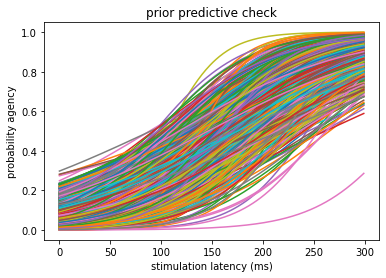

In [3]:
# prior predictive 
x = np.arange(0, 300)
p = des.posterior_predictive(x)
plt.plot(x, p)
plt.title('prior predictive check')
plt.xlabel('stimulation latency (ms)')
plt.ylabel('probability agency')
plt.show()

In [4]:
# create fake subject
JND = 140
def simulate_response(x):
    alpha = JND
    beta = 0.025
    logit = beta * (x - alpha)
    p = expit(logit)
    y = 1 if p > np.random.random() else 0
    return y

In [5]:
# simulate an experiment
N_TRIALS = 200 
results = {'x': [], 'y': [], 'fit_time': [], 'oed_time': []}
for trial in range(N_TRIALS):

    # simulate a single trial
    t1 = time()
    x = des.get_next_x(mode = 'bopt')
    t2 = time()
    y = simulate_response(x)
    t3 = time()
    des.update_model(x, y)
    t4 = time()
    
    # record trial results
    results['x'].append(x)
    results['y'].append(y)
    results['fit_time'].append(t4 - t3)
    results['oed_time'].append(t2 - t1)
    if trial % 10 == 0:
        print('finished trial %d!'%trial)


/home/johnv/anaconda3/envs/agency/lib/python3.6/site-packages/pyro/infer/svi.py:61: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  FutureWarning,
/home/johnv/repos/agency-experiment/util/oed/logistic.py:77: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(alpha_mu).float())
/home/johnv/repos/agency-experiment/util/oed/logistic.py:79: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this mi

finished trial 0!
finished trial 10!
finished trial 20!
finished trial 30!
finished trial 40!
finished trial 50!
finished trial 60!
finished trial 70!
finished trial 80!
finished trial 90!
finished trial 100!
finished trial 110!
finished trial 120!
finished trial 130!
finished trial 140!
finished trial 150!
finished trial 160!
finished trial 170!
finished trial 180!
finished trial 190!


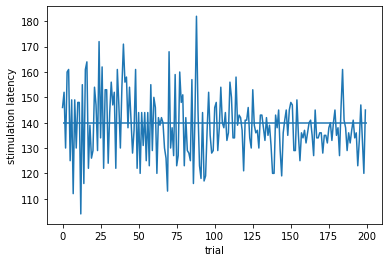

In [6]:
# display results
res = pd.DataFrame(results)
plt.plot(res.x)
plt.hlines(JND, 0, N_TRIALS)
plt.xlabel('trial')
plt.ylabel('stimulation latency')
plt.show()

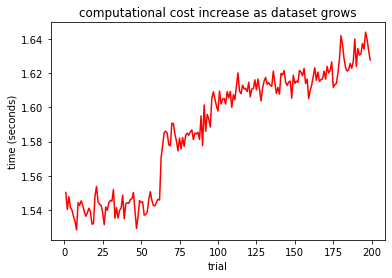

In [7]:
total = res.oed_time[1:] + res.fit_time[1:]
plt.plot(total, color = 'red')
plt.xlabel('trial')
plt.ylabel('time (seconds)')
plt.title('computational cost increase as dataset grows')
plt.show()

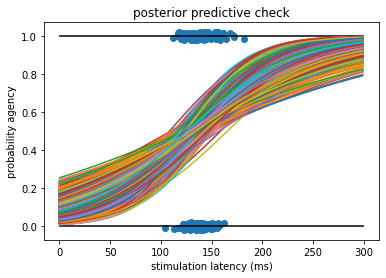

53 percent of trials had positive responses.


In [8]:
# posterior predictive 
x = np.arange(0, 300)
p = des.posterior_predictive(x)
plt.plot(x, p)
plt.title('posterior predictive check')
plt.xlabel('stimulation latency (ms)')
plt.ylabel('probability agency')
jitter = (np.random.random(res.shape[0]) - .5)/25
plt.scatter(res.x, res.y + jitter)
plt.hlines([0, 1], 0, 300, color = 'black')
plt.show()
print('%d percent of trials had positive responses.'%(np.sum(res.y)/res.shape[0] * 100))

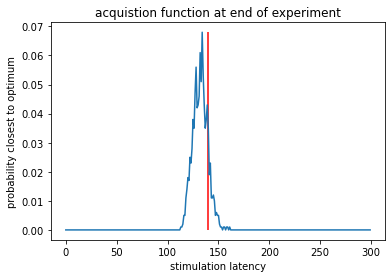

In [12]:
x, prob = des.get_probability_is_threshold()
plt.plot(x, prob)
plt.vlines(JND, 0, prob.max(), color = 'red')
plt.title('acquistion function at end of experiment')
plt.xlabel('stimulation latency')
plt.ylabel('probability closest to optimum')
plt.show()